In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from time import time
import matplotlib
import sklearn
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from sklearn.decomposition import PCA
tf.keras.backend.set_floatx('float64')
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from utilities import EdwinRueda_utils
import pickle as pk
%matplotlib inline
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, export_svgs
from bokeh.transform import jitter
from bokeh.models import ColumnDataSource
output_notebook()

print("tensorflow version: ", tf.__version__)
print("numpy version: ", np.__version__)
print("matplotlib version: ", matplotlib.__version__)
print("sklearn version: ", sklearn.__version__)

Loading BokehJS ...

tensorflow version:  2.3.3
numpy version:  1.18.5
matplotlib version:  3.3.4
sklearn version:  0.24.1


### Data upload

In [2]:
data = pd.read_csv("../data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
data.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


In [3]:
obj_rg = open("../data/reference_genes.txt")
rg = obj_rg.read().splitlines()
rg.remove("idnT")
print("Reference genes:")
print(rg)

Reference genes:
['cysG', 'hcaT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [4]:
rg_data = data.reindex(rg).dropna()
rg_data

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


## Data scaling

In [5]:
scaler = EdwinRueda_utils.scaler(xmin=-1, xmax=1)
scaler.fit(rg_data)
rg_data = scaler.transform(rg_data)
print("Reference genes scaled: ")
rg_data

Reference genes scaled: 


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


## Training the proposed GAN architecture (Best GAN architecture)

In [6]:
noise_shape = 50
num_syn_samples = 3

#Generator network
G1 = Sequential(name="Generator_network")
G1.add(Dense(50, input_shape=(noise_shape,)))
G1.add(Dense(150))
G1.add(Dropout(.15))
G1.add(Dense(9, activation="tanh"))

#synthetic sample
noise_input = tf.random_normal_initializer()((num_syn_samples, noise_shape))
print("noise input shape:", noise_input.shape)
print("---------------------------")
print("synthetic samples:")
synthetic_samples = G1(noise_input)
synthetic_samples

noise input shape: (3, 50)
---------------------------
synthetic samples:


<tf.Tensor: shape=(3, 9), dtype=float64, numpy=
array([[ 0.0055804 ,  0.01682427,  0.00496293,  0.10432881, -0.04964435,
         0.02254992,  0.03160382, -0.11181067, -0.00201627],
       [-0.00637165, -0.087593  , -0.01471667, -0.02799386, -0.04187043,
         0.0220605 , -0.03194012, -0.05096168,  0.04427241],
       [-0.0016578 , -0.05261478, -0.05443181, -0.02919957, -0.01517172,
         0.0222772 ,  0.04877545,  0.03790831,  0.03934064]])>

In [7]:
G1.summary()

Model: "Generator_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 150)               7650      
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1359      
Total params: 11,559
Trainable params: 11,559
Non-trainable params: 0
_________________________________________________________________


In [8]:
#Discriminator network
D1 = Sequential(name="Discriminator_network")
D1.add(Dense(32, input_shape=(rg_data.shape[1],), name="Dense_1"))
D1.add(tf.keras.layers.LeakyReLU(alpha=.2))
D1.add(Dense(32, name="Dense_2"))
D1.add(Dense(1, activation="sigmoid", name="Dense_3"))
print("output of the disriminator network:")
D1(synthetic_samples)

output of the disriminator network:


<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[0.51988972],
       [0.50315975],
       [0.49631187]])>

In [9]:
D1.summary()

Model: "Discriminator_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_1 (Dense)              (None, 32)                320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32)                0         
_________________________________________________________________
Dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
Dense_3 (Dense)              (None, 1)                 33        
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________


In [10]:
epochs = 1700
gan_utils1 = EdwinRueda_utils.gan_utils()
optimizerG1 = tf.optimizers.SGD(learning_rate=0.00015, momentum=.92, decay=0.00015/epochs)
optimizerD1 = tf.optimizers.SGD(learning_rate=0.001, momentum=.9, decay=0.001/epochs)
accumulated_gloss, accumulated_dloss = gan_utils1.train(rg_data, G1, D1, noise_input=noise_shape,
                                                   epochs=epochs, batch_size=rg_data.shape[0],
                                                   optimizerG=optimizerG1, optimizerD=optimizerD1,
                                                   verbose=True)

epochs[0:1700] :: G_loss[0.659138] :: D_loss[0.689591] :: time:1.149219[s]
epochs[1:1700] :: G_loss[0.702227] :: D_loss[0.669023] :: time:0.010258[s]
epochs[2:1700] :: G_loss[0.670926] :: D_loss[0.689206] :: time:0.010084[s]
epochs[3:1700] :: G_loss[0.653411] :: D_loss[0.693734] :: time:0.010151[s]
epochs[4:1700] :: G_loss[0.636783] :: D_loss[0.706804] :: time:0.010451[s]
epochs[5:1700] :: G_loss[0.678885] :: D_loss[0.674516] :: time:0.010140[s]
epochs[6:1700] :: G_loss[0.698531] :: D_loss[0.666583] :: time:0.010210[s]
epochs[7:1700] :: G_loss[0.747569] :: D_loss[0.641882] :: time:0.010381[s]
epochs[8:1700] :: G_loss[0.631782] :: D_loss[0.711354] :: time:0.010823[s]
epochs[9:1700] :: G_loss[0.670766] :: D_loss[0.682823] :: time:0.011861[s]
epochs[10:1700] :: G_loss[0.712247] :: D_loss[0.666314] :: time:0.011064[s]
epochs[11:1700] :: G_loss[0.694006] :: D_loss[0.675276] :: time:0.010434[s]
epochs[12:1700] :: G_loss[0.660837] :: D_loss[0.698013] :: time:0.010086[s]
epochs[13:1700] :: G_l

epochs[118:1700] :: G_loss[0.792710] :: D_loss[0.604707] :: time:0.011479[s]
epochs[119:1700] :: G_loss[0.827751] :: D_loss[0.580179] :: time:0.010794[s]
epochs[120:1700] :: G_loss[0.826319] :: D_loss[0.584088] :: time:0.014234[s]
epochs[121:1700] :: G_loss[0.840290] :: D_loss[0.582509] :: time:0.014262[s]
epochs[122:1700] :: G_loss[0.879792] :: D_loss[0.568296] :: time:0.013290[s]
epochs[123:1700] :: G_loss[0.714498] :: D_loss[0.647680] :: time:0.010844[s]
epochs[124:1700] :: G_loss[0.851055] :: D_loss[0.571884] :: time:0.010295[s]
epochs[125:1700] :: G_loss[0.717528] :: D_loss[0.646684] :: time:0.010470[s]
epochs[126:1700] :: G_loss[0.950333] :: D_loss[0.537231] :: time:0.010375[s]
epochs[127:1700] :: G_loss[0.808150] :: D_loss[0.591552] :: time:0.010518[s]
epochs[128:1700] :: G_loss[0.785739] :: D_loss[0.596141] :: time:0.010411[s]
epochs[129:1700] :: G_loss[0.788237] :: D_loss[0.614143] :: time:0.010092[s]
epochs[130:1700] :: G_loss[0.803827] :: D_loss[0.589296] :: time:0.010436[s]

epochs[233:1700] :: G_loss[0.809293] :: D_loss[0.588071] :: time:0.013485[s]
epochs[234:1700] :: G_loss[0.852439] :: D_loss[0.564741] :: time:0.012381[s]
epochs[235:1700] :: G_loss[0.859555] :: D_loss[0.571298] :: time:0.010520[s]
epochs[236:1700] :: G_loss[0.885204] :: D_loss[0.549106] :: time:0.010217[s]
epochs[237:1700] :: G_loss[0.814678] :: D_loss[0.577797] :: time:0.010252[s]
epochs[238:1700] :: G_loss[0.847001] :: D_loss[0.563901] :: time:0.010149[s]
epochs[239:1700] :: G_loss[0.821683] :: D_loss[0.577043] :: time:0.010141[s]
epochs[240:1700] :: G_loss[0.908048] :: D_loss[0.538603] :: time:0.010299[s]
epochs[241:1700] :: G_loss[0.855283] :: D_loss[0.555313] :: time:0.010086[s]
epochs[242:1700] :: G_loss[0.897352] :: D_loss[0.554327] :: time:0.010325[s]
epochs[243:1700] :: G_loss[0.895927] :: D_loss[0.547152] :: time:0.010304[s]
epochs[244:1700] :: G_loss[0.897445] :: D_loss[0.538752] :: time:0.010008[s]
epochs[245:1700] :: G_loss[0.898375] :: D_loss[0.545520] :: time:0.010364[s]

epochs[353:1700] :: G_loss[0.792159] :: D_loss[0.576320] :: time:0.011825[s]
epochs[354:1700] :: G_loss[0.879679] :: D_loss[0.539439] :: time:0.011915[s]
epochs[355:1700] :: G_loss[0.935237] :: D_loss[0.514995] :: time:0.010145[s]
epochs[356:1700] :: G_loss[0.876586] :: D_loss[0.536814] :: time:0.010186[s]
epochs[357:1700] :: G_loss[0.918607] :: D_loss[0.525860] :: time:0.009878[s]
epochs[358:1700] :: G_loss[0.839182] :: D_loss[0.545316] :: time:0.010233[s]
epochs[359:1700] :: G_loss[0.858314] :: D_loss[0.553351] :: time:0.009907[s]
epochs[360:1700] :: G_loss[0.835346] :: D_loss[0.551421] :: time:0.010290[s]
epochs[361:1700] :: G_loss[0.844140] :: D_loss[0.552313] :: time:0.009902[s]
epochs[362:1700] :: G_loss[0.922762] :: D_loss[0.526368] :: time:0.009896[s]
epochs[363:1700] :: G_loss[0.926485] :: D_loss[0.516739] :: time:0.009911[s]
epochs[364:1700] :: G_loss[0.914241] :: D_loss[0.521933] :: time:0.009835[s]
epochs[365:1700] :: G_loss[0.892548] :: D_loss[0.535666] :: time:0.009948[s]

epochs[470:1700] :: G_loss[0.937248] :: D_loss[0.510531] :: time:0.011635[s]
epochs[471:1700] :: G_loss[0.937979] :: D_loss[0.516047] :: time:0.014408[s]
epochs[472:1700] :: G_loss[0.824653] :: D_loss[0.558018] :: time:0.012268[s]
epochs[473:1700] :: G_loss[0.981339] :: D_loss[0.519766] :: time:0.010282[s]
epochs[474:1700] :: G_loss[0.985385] :: D_loss[0.490283] :: time:0.010298[s]
epochs[475:1700] :: G_loss[0.933540] :: D_loss[0.524979] :: time:0.010871[s]
epochs[476:1700] :: G_loss[0.875149] :: D_loss[0.532003] :: time:0.009964[s]
epochs[477:1700] :: G_loss[0.976288] :: D_loss[0.504940] :: time:0.010283[s]
epochs[478:1700] :: G_loss[0.901545] :: D_loss[0.553259] :: time:0.010328[s]
epochs[479:1700] :: G_loss[0.973945] :: D_loss[0.495791] :: time:0.011081[s]
epochs[480:1700] :: G_loss[0.976320] :: D_loss[0.498132] :: time:0.010982[s]
epochs[481:1700] :: G_loss[0.968157] :: D_loss[0.508535] :: time:0.011144[s]
epochs[482:1700] :: G_loss[0.960273] :: D_loss[0.511191] :: time:0.010946[s]

epochs[587:1700] :: G_loss[1.036304] :: D_loss[0.493331] :: time:0.013019[s]
epochs[588:1700] :: G_loss[0.978738] :: D_loss[0.529297] :: time:0.013834[s]
epochs[589:1700] :: G_loss[1.036728] :: D_loss[0.487399] :: time:0.010066[s]
epochs[590:1700] :: G_loss[0.897498] :: D_loss[0.547274] :: time:0.010110[s]
epochs[591:1700] :: G_loss[1.087740] :: D_loss[0.480182] :: time:0.010022[s]
epochs[592:1700] :: G_loss[1.092261] :: D_loss[0.472376] :: time:0.009903[s]
epochs[593:1700] :: G_loss[0.910605] :: D_loss[0.536895] :: time:0.009830[s]
epochs[594:1700] :: G_loss[0.975044] :: D_loss[0.509918] :: time:0.009891[s]
epochs[595:1700] :: G_loss[1.167416] :: D_loss[0.457202] :: time:0.010985[s]
epochs[596:1700] :: G_loss[0.937630] :: D_loss[0.513462] :: time:0.009874[s]
epochs[597:1700] :: G_loss[0.967560] :: D_loss[0.531702] :: time:0.009782[s]
epochs[598:1700] :: G_loss[0.984796] :: D_loss[0.506371] :: time:0.009860[s]
epochs[599:1700] :: G_loss[0.996532] :: D_loss[0.499752] :: time:0.009795[s]

epochs[706:1700] :: G_loss[1.082190] :: D_loss[0.499696] :: time:0.013600[s]
epochs[707:1700] :: G_loss[0.723435] :: D_loss[0.632969] :: time:0.011931[s]
epochs[708:1700] :: G_loss[1.019172] :: D_loss[0.515895] :: time:0.010263[s]
epochs[709:1700] :: G_loss[0.992552] :: D_loss[0.510632] :: time:0.009978[s]
epochs[710:1700] :: G_loss[0.889446] :: D_loss[0.567810] :: time:0.010709[s]
epochs[711:1700] :: G_loss[0.917649] :: D_loss[0.565062] :: time:0.009940[s]
epochs[712:1700] :: G_loss[0.884023] :: D_loss[0.577141] :: time:0.009866[s]
epochs[713:1700] :: G_loss[0.995073] :: D_loss[0.546074] :: time:0.009925[s]
epochs[714:1700] :: G_loss[0.999690] :: D_loss[0.526822] :: time:0.009931[s]
epochs[715:1700] :: G_loss[0.888681] :: D_loss[0.607494] :: time:0.009907[s]
epochs[716:1700] :: G_loss[1.033365] :: D_loss[0.526352] :: time:0.009954[s]
epochs[717:1700] :: G_loss[0.861086] :: D_loss[0.586246] :: time:0.010018[s]
epochs[718:1700] :: G_loss[1.140619] :: D_loss[0.492784] :: time:0.010087[s]

epochs[826:1700] :: G_loss[0.913103] :: D_loss[0.645732] :: time:0.013625[s]
epochs[827:1700] :: G_loss[0.953271] :: D_loss[0.588830] :: time:0.013384[s]
epochs[828:1700] :: G_loss[0.872326] :: D_loss[0.621996] :: time:0.010214[s]
epochs[829:1700] :: G_loss[1.114610] :: D_loss[0.505958] :: time:0.010110[s]
epochs[830:1700] :: G_loss[1.042989] :: D_loss[0.540084] :: time:0.010191[s]
epochs[831:1700] :: G_loss[0.999722] :: D_loss[0.574319] :: time:0.009940[s]
epochs[832:1700] :: G_loss[0.885337] :: D_loss[0.595398] :: time:0.009925[s]
epochs[833:1700] :: G_loss[0.876214] :: D_loss[0.609232] :: time:0.009981[s]
epochs[834:1700] :: G_loss[0.813762] :: D_loss[0.644808] :: time:0.010096[s]
epochs[835:1700] :: G_loss[0.981023] :: D_loss[0.559837] :: time:0.010666[s]
epochs[836:1700] :: G_loss[0.996938] :: D_loss[0.589229] :: time:0.009944[s]
epochs[837:1700] :: G_loss[1.000736] :: D_loss[0.564629] :: time:0.010091[s]
epochs[838:1700] :: G_loss[0.874277] :: D_loss[0.635922] :: time:0.010212[s]

epochs[942:1700] :: G_loss[1.003506] :: D_loss[0.615957] :: time:0.013091[s]
epochs[943:1700] :: G_loss[0.920230] :: D_loss[0.631846] :: time:0.013627[s]
epochs[944:1700] :: G_loss[1.023879] :: D_loss[0.597821] :: time:0.010786[s]
epochs[945:1700] :: G_loss[0.764587] :: D_loss[0.675583] :: time:0.010201[s]
epochs[946:1700] :: G_loss[0.871292] :: D_loss[0.664562] :: time:0.011939[s]
epochs[947:1700] :: G_loss[0.915293] :: D_loss[0.601572] :: time:0.010359[s]
epochs[948:1700] :: G_loss[0.746245] :: D_loss[0.688204] :: time:0.010045[s]
epochs[949:1700] :: G_loss[0.922769] :: D_loss[0.623674] :: time:0.009878[s]
epochs[950:1700] :: G_loss[1.070440] :: D_loss[0.576319] :: time:0.010707[s]
epochs[951:1700] :: G_loss[0.928565] :: D_loss[0.632788] :: time:0.010143[s]
epochs[952:1700] :: G_loss[0.849211] :: D_loss[0.648173] :: time:0.009881[s]
epochs[953:1700] :: G_loss[0.877536] :: D_loss[0.625743] :: time:0.009979[s]
epochs[954:1700] :: G_loss[0.991529] :: D_loss[0.577009] :: time:0.010006[s]

epochs[1062:1700] :: G_loss[0.818511] :: D_loss[0.684360] :: time:0.011137[s]
epochs[1063:1700] :: G_loss[0.882477] :: D_loss[0.649322] :: time:0.011937[s]
epochs[1064:1700] :: G_loss[1.056242] :: D_loss[0.609587] :: time:0.010400[s]
epochs[1065:1700] :: G_loss[0.857905] :: D_loss[0.663533] :: time:0.012248[s]
epochs[1066:1700] :: G_loss[0.925378] :: D_loss[0.631208] :: time:0.014788[s]
epochs[1067:1700] :: G_loss[0.796617] :: D_loss[0.697518] :: time:0.010117[s]
epochs[1068:1700] :: G_loss[0.876841] :: D_loss[0.661329] :: time:0.010195[s]
epochs[1069:1700] :: G_loss[1.034566] :: D_loss[0.601799] :: time:0.010149[s]
epochs[1070:1700] :: G_loss[0.892653] :: D_loss[0.673821] :: time:0.011247[s]
epochs[1071:1700] :: G_loss[0.970938] :: D_loss[0.614839] :: time:0.010007[s]
epochs[1072:1700] :: G_loss[0.786541] :: D_loss[0.717177] :: time:0.009988[s]
epochs[1073:1700] :: G_loss[0.820810] :: D_loss[0.694447] :: time:0.010015[s]
epochs[1074:1700] :: G_loss[0.944232] :: D_loss[0.643328] :: tim

epochs[1179:1700] :: G_loss[0.853136] :: D_loss[0.666941] :: time:0.011312[s]
epochs[1180:1700] :: G_loss[0.876666] :: D_loss[0.661284] :: time:0.011965[s]
epochs[1181:1700] :: G_loss[0.888273] :: D_loss[0.654062] :: time:0.010047[s]
epochs[1182:1700] :: G_loss[0.802765] :: D_loss[0.699887] :: time:0.010024[s]
epochs[1183:1700] :: G_loss[0.751994] :: D_loss[0.720101] :: time:0.010090[s]
epochs[1184:1700] :: G_loss[0.786999] :: D_loss[0.704110] :: time:0.010113[s]
epochs[1185:1700] :: G_loss[0.879987] :: D_loss[0.663864] :: time:0.010340[s]
epochs[1186:1700] :: G_loss[0.815011] :: D_loss[0.697563] :: time:0.010200[s]
epochs[1187:1700] :: G_loss[0.823749] :: D_loss[0.692672] :: time:0.010014[s]
epochs[1188:1700] :: G_loss[0.840973] :: D_loss[0.676273] :: time:0.010036[s]
epochs[1189:1700] :: G_loss[0.981871] :: D_loss[0.614162] :: time:0.009951[s]
epochs[1190:1700] :: G_loss[0.861431] :: D_loss[0.688086] :: time:0.009807[s]
epochs[1191:1700] :: G_loss[0.788722] :: D_loss[0.703370] :: tim

epochs[1295:1700] :: G_loss[0.816794] :: D_loss[0.686960] :: time:0.013881[s]
epochs[1296:1700] :: G_loss[0.829505] :: D_loss[0.683480] :: time:0.012876[s]
epochs[1297:1700] :: G_loss[0.911020] :: D_loss[0.654034] :: time:0.010120[s]
epochs[1298:1700] :: G_loss[0.792154] :: D_loss[0.697583] :: time:0.009986[s]
epochs[1299:1700] :: G_loss[0.828659] :: D_loss[0.677305] :: time:0.010288[s]
epochs[1300:1700] :: G_loss[0.835676] :: D_loss[0.682337] :: time:0.009973[s]
epochs[1301:1700] :: G_loss[0.773285] :: D_loss[0.704266] :: time:0.010052[s]
epochs[1302:1700] :: G_loss[0.898309] :: D_loss[0.657649] :: time:0.010019[s]
epochs[1303:1700] :: G_loss[0.857909] :: D_loss[0.674141] :: time:0.010002[s]
epochs[1304:1700] :: G_loss[0.818452] :: D_loss[0.687537] :: time:0.010029[s]
epochs[1305:1700] :: G_loss[0.749912] :: D_loss[0.709369] :: time:0.009996[s]
epochs[1306:1700] :: G_loss[0.995637] :: D_loss[0.611817] :: time:0.010543[s]
epochs[1307:1700] :: G_loss[0.888685] :: D_loss[0.647943] :: tim

epochs[1415:1700] :: G_loss[0.730294] :: D_loss[0.706919] :: time:0.011750[s]
epochs[1416:1700] :: G_loss[0.810243] :: D_loss[0.675574] :: time:0.012146[s]
epochs[1417:1700] :: G_loss[0.759407] :: D_loss[0.694621] :: time:0.010415[s]
epochs[1418:1700] :: G_loss[0.723495] :: D_loss[0.711727] :: time:0.010009[s]
epochs[1419:1700] :: G_loss[0.789352] :: D_loss[0.691434] :: time:0.009981[s]
epochs[1420:1700] :: G_loss[0.768643] :: D_loss[0.688934] :: time:0.010097[s]
epochs[1421:1700] :: G_loss[0.872483] :: D_loss[0.648087] :: time:0.015110[s]
epochs[1422:1700] :: G_loss[0.733096] :: D_loss[0.703527] :: time:0.015079[s]
epochs[1423:1700] :: G_loss[0.751631] :: D_loss[0.694540] :: time:0.013518[s]
epochs[1424:1700] :: G_loss[0.719815] :: D_loss[0.710762] :: time:0.013295[s]
epochs[1425:1700] :: G_loss[0.828977] :: D_loss[0.664942] :: time:0.013879[s]
epochs[1426:1700] :: G_loss[0.792261] :: D_loss[0.683167] :: time:0.010225[s]
epochs[1427:1700] :: G_loss[0.804541] :: D_loss[0.675667] :: tim

epochs[1533:1700] :: G_loss[0.742236] :: D_loss[0.688449] :: time:0.011129[s]
epochs[1534:1700] :: G_loss[0.749409] :: D_loss[0.683229] :: time:0.013121[s]
epochs[1535:1700] :: G_loss[0.837890] :: D_loss[0.650684] :: time:0.010396[s]
epochs[1536:1700] :: G_loss[0.852567] :: D_loss[0.649632] :: time:0.010079[s]
epochs[1537:1700] :: G_loss[0.865018] :: D_loss[0.641951] :: time:0.010284[s]
epochs[1538:1700] :: G_loss[0.725456] :: D_loss[0.698853] :: time:0.010364[s]
epochs[1539:1700] :: G_loss[0.776646] :: D_loss[0.680007] :: time:0.009908[s]
epochs[1540:1700] :: G_loss[0.820747] :: D_loss[0.657797] :: time:0.010027[s]
epochs[1541:1700] :: G_loss[0.793223] :: D_loss[0.670319] :: time:0.009921[s]
epochs[1542:1700] :: G_loss[0.841371] :: D_loss[0.647704] :: time:0.010402[s]
epochs[1543:1700] :: G_loss[0.684878] :: D_loss[0.718096] :: time:0.010157[s]
epochs[1544:1700] :: G_loss[0.798100] :: D_loss[0.666858] :: time:0.010067[s]
epochs[1545:1700] :: G_loss[0.767508] :: D_loss[0.680720] :: tim

epochs[1653:1700] :: G_loss[0.763091] :: D_loss[0.672263] :: time:0.011427[s]
epochs[1654:1700] :: G_loss[0.760243] :: D_loss[0.672596] :: time:0.011656[s]
epochs[1655:1700] :: G_loss[0.779461] :: D_loss[0.663907] :: time:0.010231[s]
epochs[1656:1700] :: G_loss[0.767123] :: D_loss[0.667328] :: time:0.010421[s]
epochs[1657:1700] :: G_loss[0.727554] :: D_loss[0.683883] :: time:0.009940[s]
epochs[1658:1700] :: G_loss[0.756475] :: D_loss[0.672726] :: time:0.009872[s]
epochs[1659:1700] :: G_loss[0.745300] :: D_loss[0.680564] :: time:0.009966[s]
epochs[1660:1700] :: G_loss[0.750361] :: D_loss[0.671121] :: time:0.010088[s]
epochs[1661:1700] :: G_loss[0.780792] :: D_loss[0.663089] :: time:0.010063[s]
epochs[1662:1700] :: G_loss[0.775097] :: D_loss[0.662229] :: time:0.009906[s]
epochs[1663:1700] :: G_loss[0.737712] :: D_loss[0.679864] :: time:0.010051[s]
epochs[1664:1700] :: G_loss[0.775044] :: D_loss[0.662877] :: time:0.010076[s]
epochs[1665:1700] :: G_loss[0.763898] :: D_loss[0.671747] :: tim

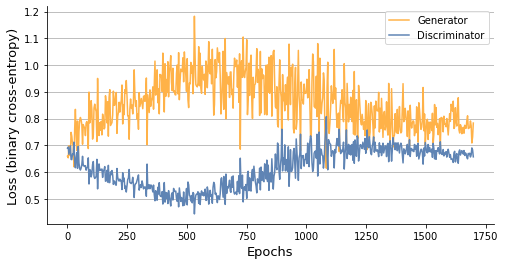

In [11]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,epochs, 3)
short_precision = [gan_utils1.precision[i] for i in rr]
short_g_loss = [accumulated_gloss[i] for i in rr]
short_d_loss = [accumulated_dloss[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(rr, short_g_loss, label="Generator", color="#FFB248")
plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4")
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss (binary cross-entropy)", fontsize=13)
plt.grid(axis="y")
plt.legend();
plt.savefig(fname="./results/best_gan_trained.svg")

In [12]:
precision, kld, loss_g, loss_d, s_metric =  gan_utils1.get_metrics(num_iter=50)

bokeh_utils = EdwinRueda_utils.bokeh_utils()

[pl_1, pq1_1, pq2_1, pq3_1, pu_1], pouts_1 = bokeh_utils.boxtplot_values(np.array(precision), True, True)
[kl_1, kq1_1, kq2_1, kq3_1, ku_1], kouts_1 = bokeh_utils.boxtplot_values(np.array(kld), True, True)
[sl_1, sq1_1, sq2_1, sq3_1, su_1], souts_1 = bokeh_utils.boxtplot_values(np.array(s_metric), True, True)

In [13]:
cats = ["precision","s_metric", "KLD"]
p = figure(plot_height=200, plot_width=350, x_range=cats, background_fill_color="white",)
p.rect(cats, [pl_1, sl_1, kl_1], width=.15, height=.001, line_color="black")
p.segment(cats, [pl_1, sl_1, kl_1], cats, [pq1_1, sq1_1, kq1_1], line_color="black")
p.vbar(cats, width=.3, top=[pq2_1, sq2_1, kq2_1], bottom=[pq1_1, sq1_1, kq1_1],
       fill_color="#3B8686", line_color="black")
p.vbar(cats, width=.3, top=[pq3_1, sq3_1, kq3_1], bottom=[pq2_1, sq2_1, kq2_1],
       fill_color="#E08E79", line_color="black")
p.segment(cats, [pq3_1, sq3_1, kq3_1], cats, [pu_1, su_1, ku_1], line_color="black")
p.rect(cats, [pu_1, su_1, ku_1], width=.15, height=.001, line_color="black")
#p.xgrid.grid_line_color = None
#p.ygrid.grid_line_color = "grey"
p.grid.grid_line_width = 1
p.yaxis.ticker = np.arange(0,1.1,.1)

#outliers
list_outs = [pouts_1, souts_1, kouts_1]
for idx in range(len(cats)):
    aux_var = list_outs[idx]
    if len(aux_var)>0:
        p.circle([cats[idx] for i in range(len(aux_var))], aux_var, line_color="#FF8000",
                fill_color="#FFA851", size=4)
    
show(p)
p.output_backend = "svg"
export_svgs(p, filename="./results/metrics_boxplot_in_unaugmented_data_gan.svg")

['./results/metrics_boxplot_in_unaugmented_data_gan.svg']

- se busca el mejor parámetro $\nu$ para el detector de novedades.

In [14]:
p = 1500
num_folds = 4
num_iter = 15
noise_vector = tf.random.normal(shape=(int((rg_data.shape[0]*p)/100), 50))
synthetic_genes = gan_utils1.G(noise_vector).numpy()
augmented_data = np.concatenate((rg_data, synthetic_genes), axis=0)
obj = EdwinRueda_utils.ocsvm_utilities(augmented_data, np.ones(augmented_data.shape[0]),k_folds=num_folds)
nu_params = 30
params = {"nu":np.linspace(.001,0.5, nu_params)}
train_score, test_score = obj.get_best_params(params, n_iter=num_iter)
train_recall_score, test_recall_score = obj.get_statistics(iterations=30, test_size=.3)

In [15]:
augmented_data.shape

(320, 9)

In [16]:
best_nu = test_score.where(test_score.best_nu==test_score.best_nu.max()).dropna().index[0]
best_nu

0.001

- separamos el conjunto de entrenamiento en train y test. Para ello, tomaremos el 70% de los genes reales para el conjunto de entrenamiento y 30% para el test.

- Repetidos 500 veces la división del 70% y 30% para generar una puntuación recall con desviación estándar.

In [79]:
train_recall_score_ocsvm = []
train_recall_score_rg = []
test_recall_score_ocsvm = []
test_recall_score_rg = []

for i in range(500):
    #generamos los índices aleatoreamente
    idx = np.random.permutation(range(rg_data.shape[0]))
    rg_70 = np.array(rg_data)[idx[:int(20*.7)]]
    noise_vector = tf.random.normal(shape=(int((rg_data.shape[0]*p)/100), 50))
    synthetic_genes = gan_utils1.G(noise_vector).numpy()
    X_train = np.concatenate((rg_70, synthetic_genes))
    rg_30 = np.array(rg_data)[idx[int(20*.7):]]
    clf = OneClassSVM(kernel="rbf", nu=best_nu, gamma="auto").fit(X_train)
    train_recall_score_ocsvm.append(recall_score(np.ones(X_train.shape[0]), clf.predict(X_train)))
    train_recall_score_rg.append(recall_score(np.ones(int(20*.7)), clf.predict(rg_70)))
    
    noise_vector = tf.random.normal(shape=(int((rg_data.shape[0]*p)/100), 50))
    synthetic_genes = gan_utils1.G(noise_vector).numpy()

    test_recall_score_ocsvm.append(recall_score(np.ones(synthetic_genes.shape[0]),clf.predict(synthetic_genes)))
    test_recall_score_rg.append(recall_score(np.ones(int(20*.3)),clf.predict(rg_30)))

In [80]:
print("mean of the recall score in the train data:", np.round(np.mean(train_recall_score_ocsvm)*100, 2))
print("std of the recall score in the train data:", np.round(np.std(train_recall_score_ocsvm)*100,2))
print("mean of the recall score in the train data (70%):", np.round(np.mean(train_recall_score_rg)*100,2))
print("std of the recall score in the train data (70%):", np.round(np.std(train_recall_score_rg)*100, 2))
print()
print("mean of the recall score in the test data:", np.round(np.mean(test_recall_score_ocsvm)*100, 2))
print("std of the recall score in the test data:", np.round(np.std(test_recall_score_ocsvm)*100,2))
print("mean of the recall score in the test data (70%):", np.round(np.mean(test_recall_score_rg)*100,2))
print("std of the recall score in the test data (70%):", np.round(np.std(test_recall_score_rg)*100,2))

mean of the recall score in the train data: 97.42
std of the recall score in the train data: 0.71
mean of the recall score in the train data (70%): 85.6
std of the recall score in the train data (70%): 7.6

mean of the recall score in the test data: 96.78
std of the recall score in the test data: 1.39
mean of the recall score in the test data (70%): 73.07
std of the recall score in the test data (70%): 16.94


In [81]:
X_unclass = data.drop(rg_data.index)
X_unclass = scaler.transform(X_unclass)
X_unclass.shape

(4168, 9)

In [82]:
predict_unclass = clf.predict(X_unclass)==1
num_cand = sum(predict_unclass)
print("número de genes candidatos:", num_cand)

número de genes candidatos: 691


In [83]:
#guardamos el detector de novedades
import pickle as pk
pk.dump(clf, open("./novelty_detector.pk","wb"))

In [88]:
print("reducción del ", np.round((1 - num_cand/X_unclass.shape[0])*100, 2),"%")

reducción del  83.42 %


In [89]:
obj_rg = open("../data/RG_artigoMoose.txt")
rg_moose = [g for g in obj_rg.read().splitlines()]
print("Genes candidatos do artigo moose:", len(rg_moose))
print(rg_moose)

Genes candidatos do artigo moose: 27
['dnaG', 'dtpB', 'ftsX', 'ftsY', 'glyY', 'gyrB', 'lhr', 'mutM', 'mutY', 'ndk', 'nfuA', 'pnp', 'rbbA', 'rhsB', 'rpsU', 'rrsE', 'rrsG', 'secB', 'spoT', 'tfaR', 'thrW', 'valS', 'yedJ', 'ynaE', 'yphG', 'zntA', 'zupT']


In [92]:
X_candidates = X_unclass.loc[predict_unclass]
X_candidates

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aas,-0.922192,-0.918634,-0.912901,-0.955073,-0.996782,-0.974946,-0.973578,-0.897515,-0.892211
accB,-0.514109,0.918962,1.020704,0.785425,0.781750,0.679621,0.702075,0.594880,0.713118
aceB,0.857671,0.777676,0.822172,0.077504,0.069610,-0.091237,-0.130144,1.031624,-0.112132
aceE,0.966515,0.934333,1.030230,0.849922,0.855701,0.749005,0.780537,0.621839,0.832078
acpP,0.240181,0.238228,0.358745,0.258240,0.250706,0.181512,0.155418,-0.072485,0.131388
...,...,...,...,...,...,...,...,...,...
ytjC,-0.903228,-0.941950,-0.867201,-0.962170,-0.963879,-0.980938,-0.997081,-0.920845,-0.925040
zapA,0.692970,0.692621,0.711157,0.804052,-0.675645,0.769246,0.742619,0.602742,0.666505
zapB,0.071121,0.054949,0.178200,0.116346,0.132872,0.030186,0.053554,-0.273880,-0.022717


In [94]:
print("most relevant cadidates:")
X_candidates.reindex(index=rg_moose).dropna()

most relevant cadidates:


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
ftsY,0.734632,0.733591,0.794660,-0.650803,0.759634,0.736101,0.682666,0.613599,0.705083
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
mutY,0.708679,0.703653,0.720573,0.741906,-0.724643,0.700263,0.635943,0.599778,0.676169
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
nfuA,0.905821,0.899027,0.987680,0.991985,0.981116,0.875800,0.849890,0.711463,0.841314
rrsE,0.587656,0.604759,0.693686,0.763962,0.745445,0.692236,0.564757,0.333634,0.588330
rrsG,-0.340691,-0.307542,-0.218399,-0.166913,-0.192341,-0.278790,-0.419332,0.789914,-0.380720
spoT,0.884382,0.884552,0.940746,0.896704,0.886937,0.848056,0.782912,0.707923,0.829242
